In [4]:
import sys
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.eeg_utils import *
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows)
from braindecode.datasets import BaseConcatDataset
from braindecode.datautil import load_concat_dataset
%load_ext autoreload
%autoreload 2
from torch import nn, optim
from torch.utils.data import DataLoader

### Load raw data

In [5]:
datasets = []
releases = list(range(9,0,-1))
hbn_datasets = ['ds005514','ds005512','ds005511','ds005510','ds005509','ds005508','ds005507','ds005506','ds005505']
hbn_release_ds = dict(zip(releases,hbn_datasets))

In [6]:
# ds1 = HBNDataset(hbn_release_ds[1], tasks=['RestingState'], num_workers=-1, preload=False)
# ds2 = HBNDataset(hbn_release_ds[6], tasks=['RestingState'], num_workers=-1, preload=False)
if not os.path.exists('data'):
    os.makedirs('data', exist_ok=True)
if not os.path.exists('data/ds005510'):
    # download zip file from google drive and put it in data folder
    # https://drive.google.com/file/d/1KWEDoZOqyLojq0hQx8lUNTWSdZ5tBlTc/view?usp=sharing
    import zipfile
    with zipfile.ZipFile('data/ds005510.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
# make sure you downloaded ds005505 and placed it in data folder
ds2 = HBNDataset(hbn_release_ds[6], tasks=['RestingState'], num_workers=-1, preload=False, data_path='data')

Scanning 1 directories... [PosixPath('data/ds005510')]
Current number of files: 0
Scanning 10 directories... ['data/ds005510/sub-NDARUT651WFC', 'data/ds005510/sub-NDARTY549YDG', 'data/ds005510/sub-NDARUC022JWT', 'data/ds005510/sub-NDARKN346XZH', 'data/ds005510/sub-NDARUK101YT3', 'data/ds005510/sub-NDARUD306BB0', 'data/ds005510/sub-NDARUP067TM8', 'data/ds005510/sub-NDARYW984FLT', 'data/ds005510/sub-NDARAE877NER', 'data/ds005510/sub-NDARUL454XRE']
Current number of files: 0
Scanning 10 directories... ['data/ds005510/sub-NDARUT651WFC/eeg', 'data/ds005510/sub-NDARTY549YDG/eeg', 'data/ds005510/sub-NDARUC022JWT/eeg', 'data/ds005510/sub-NDARKN346XZH/eeg', 'data/ds005510/sub-NDARUK101YT3/eeg', 'data/ds005510/sub-NDARUD306BB0/eeg', 'data/ds005510/sub-NDARUP067TM8/eeg', 'data/ds005510/sub-NDARYW984FLT/eeg', 'data/ds005510/sub-NDARAE877NER/eeg', 'data/ds005510/sub-NDARUL454XRE/eeg']
Adding  data/ds005510/sub-NDARUK101YT3/eeg/sub-NDARUK101YT3_task-symbolSearch_eeg.set
Adding  data/ds005510/sub-NDA

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/Users/arno/Python/eeg-ssl/notebooks/../libs/ssl_dataloader.py:48: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(f, preload=preload)
/Users/arno/Python/eeg-ssl/notebooks/../libs/ssl_dataloader.py:48: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
 

In [7]:
all_ds = BaseConcatDataset([ds2]) # [ds1, ds2]
all_ds.description

,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
1,RestingState,,,NDARTY549YDG,500,5.5486,F,-50.02,0.075,-0.646,0.324,-0.336
2,RestingState,,,NDARUC022JWT,500,16.4749,M,94.51,1.169,-1.014,-0.541,0.603
3,RestingState,,,NDARKN346XZH,500,8.4447,F,100.05,-1.401,0.225,0.214,-0.370
4,RestingState,,,NDARUK101YT3,500,11.2050,M,96.72,-1.266,-0.093,-1.056,-0.057
5,RestingState,,,NDARUD306BB0,500,12.9846,M,60.03,0.148,0.028,-0.699,0.017
6,RestingState,,,NDARUP067TM8,500,6.4986,M,100.05,-0.185,-0.183,-1.121,0.480
7,RestingState,,,NDARYW984FLT,500,8.0866,F,80.04,1.156,0.011,-1.025,0.009
8,RestingState,,,NDARAE877NER,500,11.3413,F,66.70,0.166,0.871,1.085,-0.931
9,RestingState,,,NDARUL454XRE,500,10.8901,M,-26.68,0.758,0.308,-0.555,-0.398


### Save to disk using braindecode

In [8]:
os.makedirs('data/hbn', exist_ok=True)
all_ds.save('data/hbn', overwrite=True)

Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/0/0-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/0/0-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/1/1-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/1/1-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/2/2-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/2/2-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/3/3-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/3/3-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/4/4-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/4/4-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/5/5-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/5/5-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/6/6-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn/6/6-raw.fif
[done]
Writing /Users/arno/Python/

#### Load raw data from braindecode

In [9]:
loaded_dataset = load_concat_dataset(path='data/hbn', preload=False)
all_ds = loaded_dataset

Opening raw data file data/hbn/0/0-raw.fif...
    Range : 0 ... 177228 =      0.000 ...   354.456 secs
Ready.
Opening raw data file data/hbn/1/1-raw.fif...
    Range : 0 ... 175608 =      0.000 ...   351.216 secs
Ready.
Opening raw data file data/hbn/2/2-raw.fif...
    Range : 0 ... 170736 =      0.000 ...   341.472 secs
Ready.
Opening raw data file data/hbn/3/3-raw.fif...
    Range : 0 ... 179161 =      0.000 ...   358.322 secs
Ready.
Opening raw data file data/hbn/4/4-raw.fif...
    Range : 0 ... 181377 =      0.000 ...   362.754 secs
Ready.
Opening raw data file data/hbn/5/5-raw.fif...
    Range : 0 ... 176177 =      0.000 ...   352.354 secs
Ready.
Opening raw data file data/hbn/6/6-raw.fif...
    Range : 0 ... 206078 =      0.000 ...   412.156 secs
Ready.
Opening raw data file data/hbn/7/7-raw.fif...
    Range : 0 ... 177202 =      0.000 ...   354.404 secs
Ready.
Opening raw data file data/hbn/8/8-raw.fif...
    Range : 0 ... 175903 =      0.000 ...   351.806 secs
Ready.
Opening ra

### Visualize data sample

Effective window size : 4.096 (s)


/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_13832/1483036961.py:2: UserWarning: Zero value in spectrum for channels E26, E67, E128, Cz
  fig = raw.compute_psd(fmax=70).plot(
/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_13832/1483036961.py:2: UserWarning: Infinite value in PSD for channels E26, E67, E128, Cz.
These channels might be dead.
  fig = raw.compute_psd(fmax=70).plot(
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


sampling_freq: 500.0
(array([[ 0.00086309,  0.00087592,  0.0008527 , ..., -0.00587942,
        -0.00591204, -0.00586787]]), array([ 10.   ,  10.002,  10.004, ..., 351.212, 351.214, 351.216]))
-0.007071018048553646 0.0020650854440049105


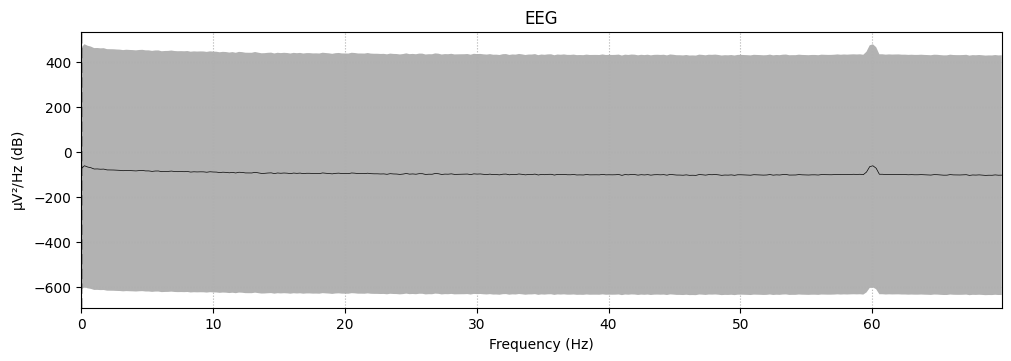

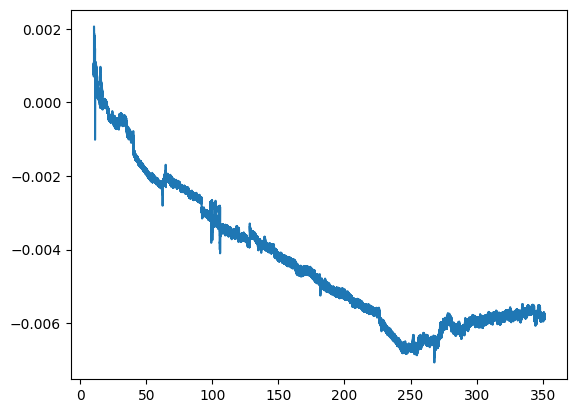

In [10]:
raw = all_ds.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling_freq:', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

### Preprocess data

In [12]:
from numpy import multiply
from sklearn.preprocessing import scale as standard_scale

os.makedirs('data/hbn_preprocessed', exist_ok=True)

sampling_rate = 250 # resample to follow the tutorial sampling rate
high_cut_hz = 59
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
    #Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('crop', tmin=10),  # crop first 10 seconds as begining of noise recording
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz),
    Preprocessor('resample', sfreq=sampling_rate),
    Preprocessor('notch_filter', freqs=(60, 120)),
    Preprocessor(standard_scale, channel_wise=True),
]

# Transform the data
preprocess(all_ds, preprocessors, save_dir='data/hbn_preprocessed', overwrite=True, n_jobs=-1)

Reading 0 ... 174161  =      0.000 ...   348.322 secs...
Reading 0 ... 176377  =      0.000 ...   352.754 secs...
Reading 0 ... 172202  =      0.000 ...   344.404 secs...
Reading 0 ... 165736  =      0.000 ...   331.472 secs...
Reading 0 ... 201078  =      0.000 ...   402.156 secs...
Reading 0 ... 170608  =      0.000 ...   341.216 secs...
Reading 0 ... 172228  =      0.000 ...   344.456 secs...
Reading 0 ... 171177  =      0.000 ...   342.354 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz
Filtering raw data in 1 contiguous segment

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
Setting up low-pass filter at 59 Hz
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz

- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
Filtering raw data in 1 contiguous segment
FIR filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Reading 0 ... 171625  =      0.000 ...   343.250 secs...
Reading 0 ... 170903  =      0.000 ...   341.806 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard dev

Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/4/4-raw.fif
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/1/1-raw.fif
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/7/7-raw.fif
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/3/3-raw.fif
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/5/5-raw.fif


/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/2/2-raw.fif
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/0/0-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/4/4-raw.fif
[done]
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/1/1-raw.fif
[done]
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/7/7-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/3/3-raw.fif
[done]
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/5/5-raw.fif
[d

/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['4'].
  warnings.warn(f'Chosen directory {path} contains other '
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['1', '4'].
  warnings.warn(f'Chosen directory {path} contains other '
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['7', '1', '4'].
  warnings.warn(f'Chosen directory {path} contains other '
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['7', '1', '4', '3'].
  warnings.warn(f

Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/2/2-raw.fif
[done]
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/0/0-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/6/6-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['0', '7', '1', '4', '3', '2', '5'].
  warnings.warn(f'Chosen directory {path} contains other '


Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/6/6-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/8/8-raw.fif
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/9/9-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/8/8-raw.fif
[done]
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed/9/9-raw.fif
[done]
Opening raw data file data/hbn_preprocessed/0/0-raw.fif...
    Range : 2500 ... 88613 =     10.000 ...   354.452 secs
Ready.
Opening raw data file data/hbn_preprocessed/1/1-raw.fif...
    Range : 2500 ... 87803 =     10.000 ...   351.212 secs
Ready.
Opening raw data file data/hbn_preprocessed/2/2-raw.fif...
    Range : 2500 ... 85367 =     10.000 ...   341.468 secs
Ready.
Opening raw data file data/hbn_preprocessed/3/3-raw.fif...


/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['0', '7', '6', '1', '4', '3', '2', '5'].
  warnings.warn(f'Chosen directory {path} contains other '
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['0', '7', '6', '1', '8', '4', '3', '2', '5'].
  warnings.warn(f'Chosen directory {path} contains other '


    Range : 2500 ... 89580 =     10.000 ...   358.320 secs
Ready.
Opening raw data file data/hbn_preprocessed/4/4-raw.fif...
    Range : 2500 ... 90688 =     10.000 ...   362.752 secs
Ready.
Opening raw data file data/hbn_preprocessed/5/5-raw.fif...
    Range : 2500 ... 88088 =     10.000 ...   352.352 secs
Ready.
Opening raw data file data/hbn_preprocessed/6/6-raw.fif...
    Range : 2500 ... 103039 =     10.000 ...   412.156 secs
Ready.
Opening raw data file data/hbn_preprocessed/7/7-raw.fif...
    Range : 2500 ... 88601 =     10.000 ...   354.404 secs
Ready.
Opening raw data file data/hbn_preprocessed/8/8-raw.fif...
    Range : 2500 ... 87951 =     10.000 ...   351.804 secs
Ready.
Opening raw data file data/hbn_preprocessed/9/9-raw.fif...
    Range : 2500 ... 88312 =     10.000 ...   353.248 secs
Ready.


#### Load preprocessed data using braindecode

In [31]:
loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
all_ds = loaded_dataset
all_ds.datasets[0].description

task             RestingState
session                      
run                          
subject          NDARUT651WFC
sfreq                     500
age                   17.4851
sex                         F
ehq_total              100.05
p_factor                 1.52
attention               0.161
internalizing           0.459
externalizing           0.836
dtype: object

In [33]:
all_ds.description

,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
1,RestingState,,,NDARTY549YDG,500,5.5486,F,-50.02,0.075,-0.646,0.324,-0.336
2,RestingState,,,NDARUC022JWT,500,16.4749,M,94.51,1.169,-1.014,-0.541,0.603
3,RestingState,,,NDARKN346XZH,500,8.4447,F,100.05,-1.401,0.225,0.214,-0.370
4,RestingState,,,NDARUK101YT3,500,11.2050,M,96.72,-1.266,-0.093,-1.056,-0.057
5,RestingState,,,NDARUD306BB0,500,12.9846,M,60.03,0.148,0.028,-0.699,0.017
6,RestingState,,,NDARUP067TM8,500,6.4986,M,100.05,-0.185,-0.183,-1.121,0.480
7,RestingState,,,NDARYW984FLT,500,8.0866,F,80.04,1.156,0.011,-1.025,0.009
8,RestingState,,,NDARAE877NER,500,11.3413,F,66.70,0.166,0.871,1.085,-0.931
9,RestingState,,,NDARUL454XRE,500,10.8901,M,-26.68,0.758,0.308,-0.555,-0.398


Effective window size : 8.192 (s)
sampling rate 250.0
(array([[ 2.20384299,  2.20364999,  2.20258449, ..., -0.75915894,
        -0.78561556, -0.81883519]]), array([ 10.   ,  10.004,  10.008, ..., 341.204, 341.208, 341.212]))
-1.396258996474785 2.209932494420457


/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_13832/1673914308.py:2: UserWarning: Zero value in spectrum for channel Cz
  fig = raw.compute_psd(fmax=70).plot(
/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_13832/1673914308.py:2: UserWarning: Infinite value in PSD for channel Cz.
These channels might be dead.
  fig = raw.compute_psd(fmax=70).plot(
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


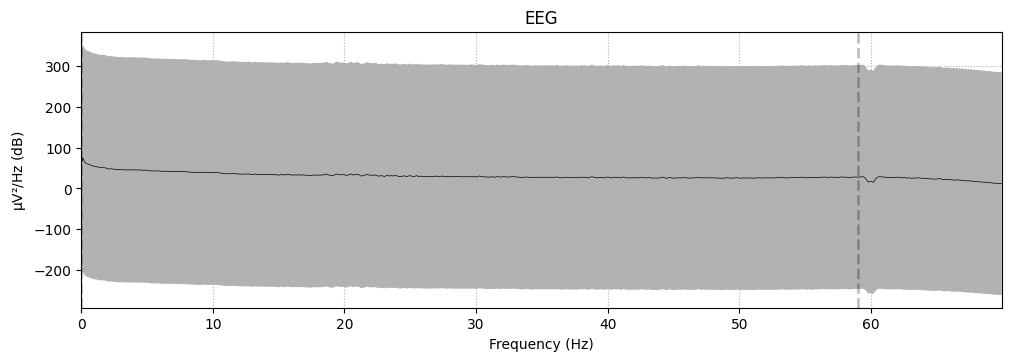

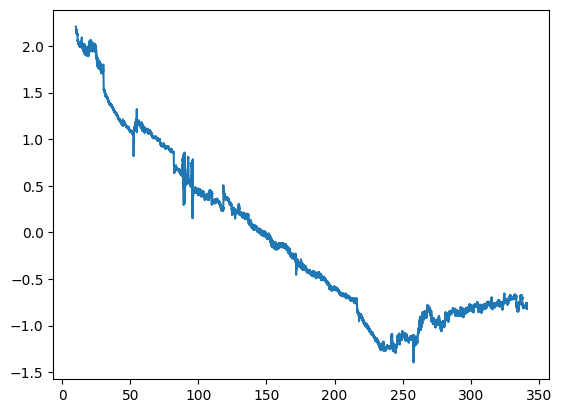

In [34]:
raw = all_ds.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling rate', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

### Set labels

In [35]:
target_name = 'age'
for ds in all_ds.datasets:
    ds.target_name = target_name

### Segment data windows

In [36]:
window_len_s = 10
fs = all_ds.datasets[0].raw.info['sfreq']
print('sampling rate', fs)
window_len_samples = int(fs * window_len_s)
window_stride_samples = int(fs * window_len_s) # non-overlapping
windows_ds = create_fixed_length_windows(
    all_ds, start_offset_samples=0, stop_offset_samples=None,
    window_size_samples=window_len_samples,
    window_stride_samples=window_stride_samples, drop_last_window=True,
    preload=False)

sampling rate 250.0


In [37]:
os.makedirs('data/hbn_preprocessed_windowed_scaled', exist_ok=True)
windows_ds.save('data/hbn_preprocessed_windowed_scaled', overwrite=True)

Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/0/0-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/0/0-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/1/1-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/1/1-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/2/2-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/2/2-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/3/3-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/3/3-raw.fif
[done]
Writing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/4/4-raw.fif
Closing /Users/arno/Python/eeg-ssl/notebooks/data/hbn_preprocessed_windowed_scaled/4/4-raw.fif
[done]
Writing /Users/

#### Load segmented data windows

In [38]:
window_len_s = 10

In [39]:
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_windowed_scaled', preload=False)

Opening raw data file data/hbn_preprocessed_windowed_scaled/0/0-raw.fif...
    Range : 2500 ... 88613 =     10.000 ...   354.452 secs
Ready.
Opening raw data file data/hbn_preprocessed_windowed_scaled/1/1-raw.fif...
    Range : 2500 ... 87803 =     10.000 ...   351.212 secs
Ready.
Opening raw data file data/hbn_preprocessed_windowed_scaled/2/2-raw.fif...
    Range : 2500 ... 85367 =     10.000 ...   341.468 secs
Ready.
Opening raw data file data/hbn_preprocessed_windowed_scaled/3/3-raw.fif...
    Range : 2500 ... 89580 =     10.000 ...   358.320 secs
Ready.
Opening raw data file data/hbn_preprocessed_windowed_scaled/4/4-raw.fif...
    Range : 2500 ... 90688 =     10.000 ...   362.752 secs
Ready.
Opening raw data file data/hbn_preprocessed_windowed_scaled/5/5-raw.fif...
    Range : 2500 ... 88088 =     10.000 ...   352.352 secs
Ready.
Opening raw data file data/hbn_preprocessed_windowed_scaled/6/6-raw.fif...
    Range : 2500 ... 103039 =     10.000 ...   412.156 secs
Ready.
Opening raw 

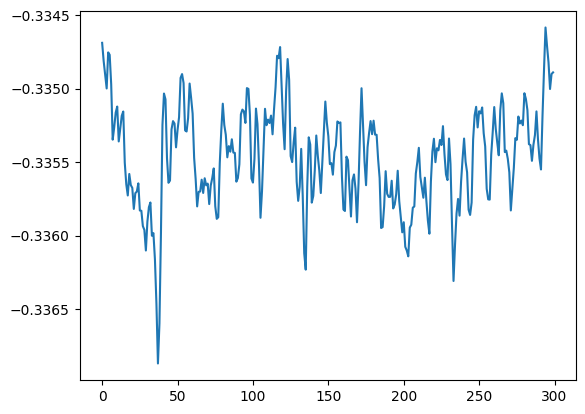

In [40]:
sample_range = list(range(300))
plt.plot(sample_range, windows_ds[100][0][0,sample_range])
plt.show()

### Train-test split

In [41]:
random_state = 87
n_jobs = -1

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split

subjects = np.unique(windows_ds.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

In [43]:

split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_ds.datasets
         if ds.description['subject'] in values])


In [44]:
print('train datasets', len(splitted['train'].datasets))
print('validation datasets', len(splitted['valid'].datasets))
print('test datasets', len(splitted['test'].datasets))
splitted['train'].get_metadata()

train datasets 6
validation datasets 2
test datasets 2


,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,0,0,2500,17.4851,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
1,1,2500,5000,17.4851,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
2,2,5000,7500,17.4851,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
3,3,7500,10000,17.4851,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
4,4,10000,12500,17.4851,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,29,72500,75000,10.8901,RestingState,,,NDARUL454XRE,500,10.8901,M,-26.68,0.758,0.308,-0.555,-0.398
30,30,75000,77500,10.8901,RestingState,,,NDARUL454XRE,500,10.8901,M,-26.68,0.758,0.308,-0.555,-0.398
31,31,77500,80000,10.8901,RestingState,,,NDARUL454XRE,500,10.8901,M,-26.68,0.758,0.308,-0.555,-0.398
32,32,80000,82500,10.8901,RestingState,,,NDARUL454XRE,500,10.8901,M,-26.68,0.758,0.308,-0.555,-0.398


In [45]:
from braindecode.samplers import RelativePositioningSampler

sfreq = 250
tau_pos, tau_neg = int(sfreq * 10), int(sfreq * 2 * 10)
n_examples_train = 50 * len(splitted['train'].datasets)
n_examples_valid = 50 * len(splitted['valid'].datasets)
n_examples_test = 50 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=False, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=False,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=False,
    random_state=random_state).presample()

### Specify and train model with Torch Lightning

In [48]:
import lightning as L
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
# define the LightningModule
class LitSSL(L.LightningModule):
    def __init__(self, n_channels, sfreq, input_size_samples, window_len_s, emb_size, dropout=0.5):
        super().__init__()
        self.emb = self.create_embedding_layer(n_channels, sfreq, input_size_samples, window_len_s) #VGGSSL()
        self.pooling = nn.AdaptiveAvgPool2d(32)
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024, emb_size),
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def create_embedding_layer(self, n_channels, sfreq, input_size_samples, window_len_s):
        return ShallowFBCSPNet(
            n_chans=n_channels,
            sfreq=sfreq,
            n_outputs=emb_size,
            # n_conv_chs=16,
            n_times=input_size_samples,
            input_window_seconds=window_len_s,
            # dropout=0,
            # apply_batch_norm=True,
        )

    def embed(self, x):
        z = self.clf[1](self.pooling(self.emb(x)).flatten(start_dim=1))
        return z

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        self.emb.train()
        X, y = batch
        x1, x2 = X[0], X[1]
        z1, z2 = self.emb(x1), self.emb(x2)
        z = self.pooling(torch.abs(z1 - z2)).flatten(start_dim=1)

        loss = nn.functional.binary_cross_entropy_with_logits(self.clf(z).flatten(), y)

        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        from sklearn import linear_model
        regr = linear_model.LinearRegression()
        X, Y, _ = batch
        z = self.embed(X).detach().cpu().numpy()
        Y = Y.detach().cpu().numpy()
        isnan = np.isnan(Y)
        embs = z[~isnan]
        labels = Y[~isnan]
        regr.fit(embs, labels)
        score = regr.score(embs, labels) 
        self.log('val_score', score)
        

    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_ds[0][0].shape
emb_size = 100
classes = list(range(5))

model = LitSSL(n_channels, sfreq, input_size_samples, window_len_s, emb_size)

/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [49]:
train_loader = DataLoader(splitted['train'], sampler=train_sampler, batch_size=128, num_workers=4)
splitted['valid'].return_pair = False
val_loader = DataLoader(splitted['valid'], batch_size=128, num_workers=4)
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=1, accelerator='cpu')
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader) #, ckpt_path="lightning_logs/version_10/checkpoints/epoch=199-step=20000.ckpt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | emb     | ShallowFBCSPNet   | 327 K  | eval 
1 | pooling | AdaptiveAvgPool2d | 0      | train
2 | clf     | Sequential        | 102 K  | train
------------------------------------------------------
430 K     Trainable params
0         Non-trainable params
430 K     Total params
1.721     Total estimated model params size (MB)
10        Modules in train mode
11        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/arno/Python/eeg-ssl/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 3/3 [00:16<00:00,  0.18it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3/3 [00:16<00:00,  0.18it/s, v_num=12]


In [64]:
# Load the TensorBoard notebook extension
%load_ext tensorboard